In [17]:
import simpy
import random
import statistics

# =====================================================
# 0. RANDOM SEED (FOR FIXED OUTPUT)
# =====================================================
random.seed(42)

# =====================================================
# 1. SYSTEM PARAMETERS
# =====================================================

SIM_TIME = 480                 # 8:00 AM – 4:00 PM (minutes)
REPLICATIONS = 10

# Clinic dispensary configuration
COUNTERS = 3
PHARMACISTS_PER_COUNTER = 2
TOTAL_PHARMACISTS = COUNTERS * PHARMACISTS_PER_COUNTER

# Empirical inter-arrival times (minutes)
EMPIRICAL_INTERARRIVALS = [
    0.8, 0.8, 1.0, 1.2, 0.9, 0.7,
    1.1, 0.5, 0.6, 1.0, 0.8, 0.9
]

# Empirical service times (minutes)
SERVICE_TIMES = [5, 6, 7]

# Additional barcode / coordination delay
BARCODE_DELAY = 1


# =====================================================
# 2. METRICS CLASS
# =====================================================

class Metrics:
    def __init__(self):
        self.waiting_times = []
        self.queue_lengths = []
        self.busy_time = 0.0
        self.completed = 0


# =====================================================
# 3. PATIENT PROCESS
# =====================================================

def patient(env, pharmacists, metrics, fast_service=False):
    arrival_time = env.now
    metrics.queue_lengths.append(len(pharmacists.queue))

    with pharmacists.request() as req:
        yield req

        wait = env.now - arrival_time
        metrics.waiting_times.append(wait)

        # Barcode delay
        yield env.timeout(BARCODE_DELAY)

        # Service time
        if fast_service:
            service_time = random.uniform(4, 5)
        else:
            service_time = random.choice(SERVICE_TIMES)

        start = env.now
        yield env.timeout(service_time)

        metrics.busy_time += env.now - start
        metrics.completed += 1


# =====================================================
# 4. ARRIVAL PROCESS
# =====================================================

def arrival_generator(env, pharmacists, metrics, interarrival_times, fast_service):
    while True:
        env.process(patient(env, pharmacists, metrics, fast_service))
        yield env.timeout(random.choice(interarrival_times))
        if env.now > SIM_TIME:
            break


# =====================================================
# 5. SINGLE SIMULATION RUN
# =====================================================

def run_simulation(interarrival_times, num_pharmacists, fast_service=False):
    env = simpy.Environment()
    pharmacists = simpy.Resource(env, capacity=num_pharmacists)
    metrics = Metrics()

    env.process(arrival_generator(
        env, pharmacists, metrics, interarrival_times, fast_service
    ))

    env.run(until=SIM_TIME)

    utilization = metrics.busy_time / (num_pharmacists * SIM_TIME)

    

    return {
        "Avg Wait (min)": statistics.mean(metrics.waiting_times),
        "Avg Queue": statistics.mean(metrics.queue_lengths),
        "Throughput/hr": (metrics.completed / SIM_TIME) * 60,
        "Utilization (%)": utilization * 100,
        "Patients Served": metrics.completed
    }


# =====================================================
# 6. MULTIPLE REPLICATIONS
# =====================================================

def experiment(interarrival_times, num_pharmacists, fast_service=False):
    results = [
        run_simulation(interarrival_times, num_pharmacists, fast_service)
        for _ in range(REPLICATIONS)
    ]

    return {
        "Avg Wait (min)": statistics.mean(r["Avg Wait (min)"] for r in results),
        "Avg Queue": statistics.mean(r["Avg Queue"] for r in results),
        "Throughput/hr": statistics.mean(r["Throughput/hr"] for r in results),
        "Utilization (%)": statistics.mean(r["Utilization (%)"] for r in results),
        "Patients Served": statistics.mean(r["Patients Served"] for r in results)
    }


# =====================================================
# 7. SCENARIOS
# =====================================================

results = []

# Scenario 1: Baseline
results.append({
    "Scenario": "Baseline (3 Counters, 6 Pharmacists)",
    **experiment(EMPIRICAL_INTERARRIVALS, TOTAL_PHARMACISTS)
})

# Scenario 2: +1 Counter
results.append({
    "Scenario": "+1 Counter (4 Counters, 8 Pharmacists)",
    **experiment(EMPIRICAL_INTERARRIVALS, 8)
})

# Scenario 3: Faster Service
results.append({
    "Scenario": "Faster Service (4–5 min)",
    **experiment(EMPIRICAL_INTERARRIVALS, TOTAL_PHARMACISTS, fast_service=True)
})


# =====================================================
# 8. FORMATTED OUTPUT (LIKE IMAGE STYLE)
# =====================================================

print("=" * 60)
print("HORANA DISTRICT GENERAL HOSPITAL – CLINIC DISPENSARY")
print("PERFORMANCE SIMULATION")
print("Simulation Duration: 8 Hours (480 Minutes)")
print("=" * 60)

for r in results:
    print("\n" + "=" * 60)
    print(f"SCENARIO: {r['Scenario'].upper()}")
    print("=" * 60)

    print(f"Mean Waiting Time   : {r['Avg Wait (min)']:.2f} minutes")
    print(f"Mean Queue Length   : {r['Avg Queue']:.2f} patients")
    print(f"Patients Served    : {r['Patients Served']:.0f} patients")
    print(f"Throughput         : {r['Throughput/hr']:.2f} patients/hour")
    print(f"Utilization        : {r['Utilization (%)']:.2f} %")


HORANA DISTRICT GENERAL HOSPITAL – CLINIC DISPENSARY
PERFORMANCE SIMULATION
Simulation Duration: 8 Hours (480 Minutes)

SCENARIO: BASELINE (3 COUNTERS, 6 PHARMACISTS)
Mean Waiting Time   : 63.08 minutes
Mean Queue Length   : 73.51 patients
Patients Served    : 406 patients
Throughput         : 50.80 patients/hour
Utilization        : 84.76 %

SCENARIO: +1 COUNTER (4 COUNTERS, 8 PHARMACISTS)
Mean Waiting Time   : 4.98 minutes
Mean Queue Length   : 5.35 patients
Patients Served    : 540 patients
Throughput         : 67.51 patients/hour
Utilization        : 84.23 %

SCENARIO: FASTER SERVICE (4–5 MIN)
Mean Waiting Time   : 14.40 minutes
Mean Queue Length   : 16.25 patients
Patients Served    : 518 patients
Throughput         : 64.80 patients/hour
Utilization        : 80.95 %


In [18]:
import pandas as pd

results_df = pd.DataFrame(results)

results_df


,Scenario,Avg Wait (min),Avg Queue,Throughput/hr,Utilization (%),Patients Served
0,"Baseline (3 Counters, 6 Pharmacists)",63.083547,73.510597,50.8000,84.763889,406.4
1,"+1 Counter (4 Counters, 8 Pharmacists)",4.978954,5.351201,67.5125,84.226562,540.1
2,Faster Service (4–5 min),14.395907,16.251650,64.8000,80.949809,518.4


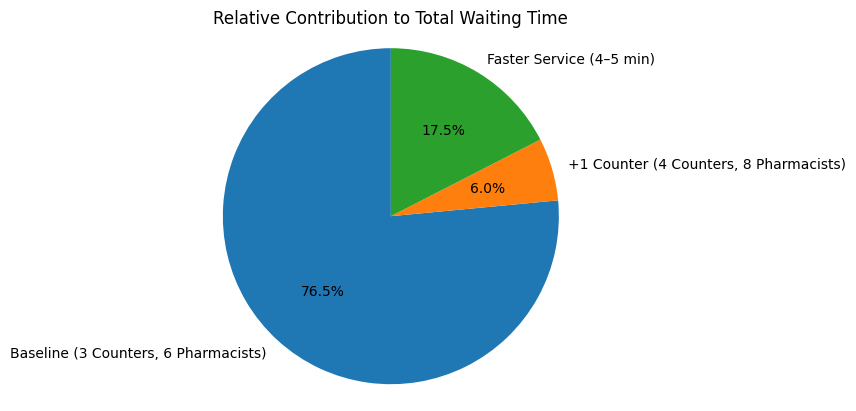

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.pie(
    results_df["Avg Wait (min)"],
    labels=results_df["Scenario"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Relative Contribution to Total Waiting Time")
plt.axis("equal")
plt.show()



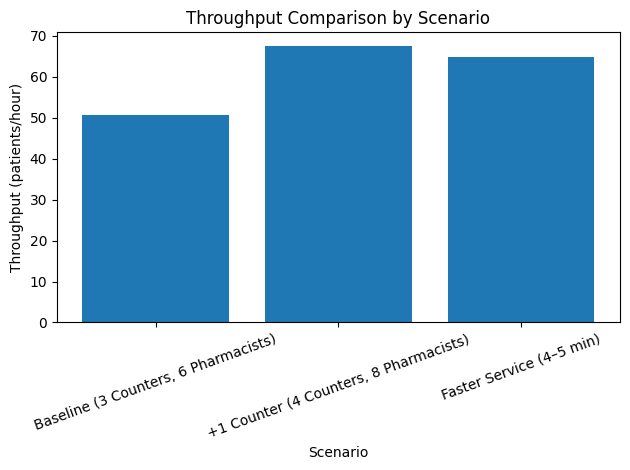

In [12]:
plt.figure()
plt.bar(
    results_df["Scenario"],
    results_df["Throughput/hr"]
)
plt.xlabel("Scenario")
plt.ylabel("Throughput (patients/hour)")
plt.title("Throughput Comparison by Scenario")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



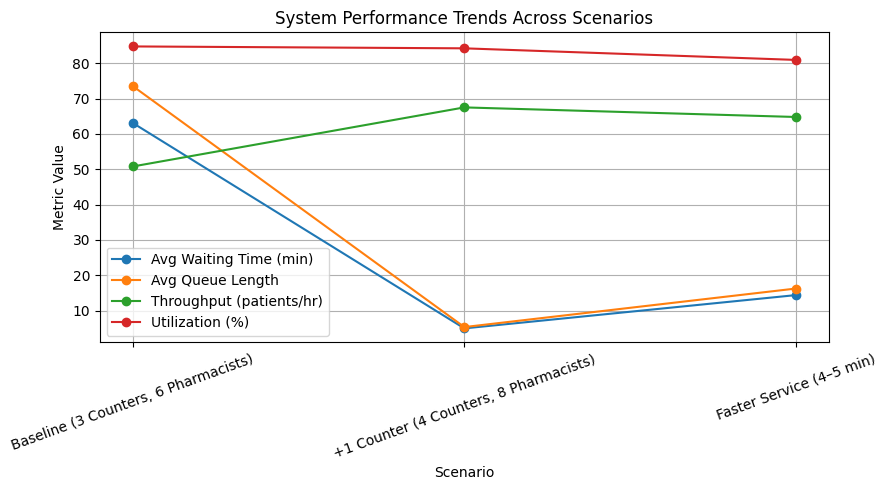

In [20]:
import matplotlib.pyplot as plt

scenarios = results_df["Scenario"]

plt.figure(figsize=(9, 5))

plt.plot(scenarios, results_df["Avg Wait (min)"], marker='o', label="Avg Waiting Time (min)")
plt.plot(scenarios, results_df["Avg Queue"], marker='o', label="Avg Queue Length")
plt.plot(scenarios, results_df["Throughput/hr"], marker='o', label="Throughput (patients/hr)")
plt.plot(scenarios, results_df["Utilization (%)"], marker='o', label="Utilization (%)")

plt.xlabel("Scenario")
plt.ylabel("Metric Value")
plt.title("System Performance Trends Across Scenarios")
plt.xticks(rotation=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


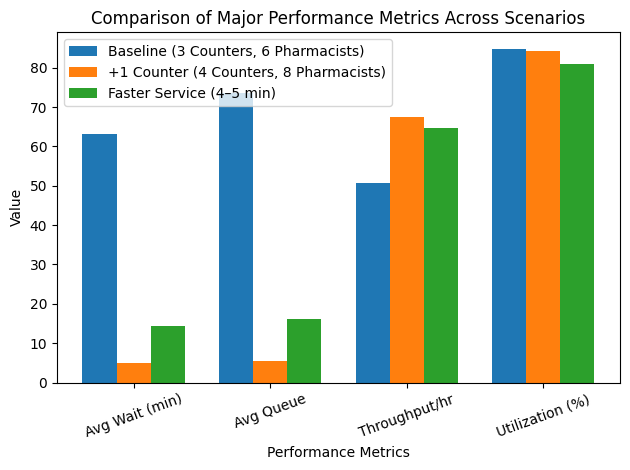

In [21]:
import numpy as np

metrics = ["Avg Wait (min)", "Avg Queue", "Throughput/hr", "Utilization (%)"]
x = np.arange(len(metrics))
width = 0.25

plt.figure()

for i, scenario in enumerate(results_df["Scenario"]):
    plt.bar(
        x + i * width,
        results_df.loc[i, metrics],
        width,
        label=scenario
    )

plt.xlabel("Performance Metrics")
plt.ylabel("Value")
plt.title("Comparison of Major Performance Metrics Across Scenarios")
plt.xticks(x + width, metrics, rotation=20)
plt.legend()
plt.tight_layout()
plt.show()
